# Предсказание цен на автомобили
<br>

Представим, что вы работаете в компании, занимающейся размещением объявлений о продаже подержанных автомобилей. Вы собрали данные о ценах подержанных автомобилей, на август 2020. Однако в вашей системе есть объявления, в которых есть описание автомобиля, но не указана цена. Команда аналитики пришла к вам и рассказала, что эти объявления без цены по набору признаков соответствуют вашей генеральной совокупности (то есть это не систематическая ошибка в какой-то конкретной области: дорогих автомобилях, каком-то регионе размещения объявления), а значит вы можете попробовать предсказать цену на эти автомобили по собранным данным. Чтобы сделать такую модель, вам нужно на имеющихся у вас данных научиться хотя бы с точностью до 1900 фунтов в среднем (а лучше меньше) предсказывать цену автомобиля. Нужно построить модель, которая будет предсказывать цену автомобиля по его характеристикам:

- **model** - Модель автомобиля
- **year** - год производства
- **transmission** - тип трасмиссии (автомат/механика/полуавтомат)
- **mileage** - пробег в милях
- **fuelType** - используемый тип топлива
- **tax** - включенный в стоимость автомобиля налог
- **mpg (miles per gallon)** - сколько миль авто может проехать на 3,78 литрах топлива
- **engineSize** - объем двигателя
- **car_maker** - производитель

Целевая переменная лежит в файле linreg_y_train.csv (цена автомобиля)

**Ваша задача предсказать цену автомобиля так, чтобы MAE (средняя абсолютная ошибка) на тестовой выборке была не более 1800.**

**Формат сдачи**

В качестве ответа нужно загрузить в систему csv-файл с двумя колонками: id и price. id - идентификатор из файла linreg_test.csv, а price - предсказанная вами цена автомобиля.

Вы получите __5__ баллов, если `MAE < 1900` и __10__ баллов если `MAE < 1800`

<hr>

### 1. Загрузка данных и EDA

In [1]:
# Импорт библиотек
import pandas as pd
import numpy as np

from sklearn import pipeline, preprocessing, model_selection
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error as mae
from sklearn import set_config

import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Настройки
SEED = 42
pd.set_option('display.max_column', None)
set_config(display='diagram')

In [3]:
# Загрузим все имеющиеся данные
x_train = pd.read_csv('datasets/linreg_train.csv', sep=',').drop('Unnamed: 0', axis=1)
y_train = pd.read_csv('datasets/linreg_y_train.csv', sep=',').drop('Unnamed: 0', axis=1)
train_df = pd.concat([x_train, y_train], axis=1)

x_predict = pd.read_csv('datasets/linreg_test.csv', sep=',', index_col=0)

In [4]:
# Посмотрим на наши данные для обучения модели
train_df.head()

,model,year,transmission,mileage,fuelType,tax,mpg,engineSize,car_maker,price
0,Passat,2019,Manual,15435,Diesel,150,51.4,2.0,vw,16795
1,A Class,2019,Semi-Auto,17945,Diesel,145,65.7,1.5,mercedes,18480
2,Focus,2017,Manual,20102,Petrol,20,60.1,1.0,ford,9995
3,C-HR,2018,Automatic,8661,Hybrid,135,74.3,1.8,toyota,20995
4,Fiesta,2020,Manual,10,Petrol,150,58.9,1.0,ford,17000


In [5]:
# Посмотрим на характеристики датафрейма
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64556 entries, 0 to 64555
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   model         64556 non-null  object 
 1   year          64556 non-null  int64  
 2   transmission  64556 non-null  object 
 3   mileage       64556 non-null  int64  
 4   fuelType      64556 non-null  object 
 5   tax           64556 non-null  int64  
 6   mpg           64556 non-null  float64
 7   engineSize    64556 non-null  float64
 8   car_maker     64556 non-null  object 
 9   price         64556 non-null  int64  
dtypes: float64(2), int64(4), object(4)
memory usage: 4.9+ MB


In [6]:
# Посмотрим на наши данные для получения прогноза модели
x_predict.head()

,model,year,transmission,mileage,fuelType,tax,mpg,engineSize,car_maker,id
0,C-MAX,2017,Manual,26805,Diesel,145,68.9,1.5,ford,0
1,1 Series,2017,Manual,24104,Petrol,125,53.3,1.5,bmw,1
2,T-Cross,2019,Manual,4899,Petrol,145,47.9,1.0,vw,2
3,A1,2019,Automatic,7000,Petrol,145,47.1,1.0,audi,3
4,Yaris,2016,Automatic,35588,Hybrid,0,86.0,1.5,toyota,4


In [7]:
# Посмотрим на характеристику тестовой выборки
x_predict.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16139 entries, 0 to 16138
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   model         16139 non-null  object 
 1   year          16139 non-null  int64  
 2   transmission  16139 non-null  object 
 3   mileage       16139 non-null  int64  
 4   fuelType      16139 non-null  object 
 5   tax           16139 non-null  int64  
 6   mpg           16139 non-null  float64
 7   engineSize    16139 non-null  float64
 8   car_maker     16139 non-null  object 
 9   id            16139 non-null  int64  
dtypes: float64(2), int64(4), object(4)
memory usage: 1.4+ MB


In [8]:
# Выделим количественные переменные и категориальные
numeric_columns = [col for col in train_df.columns if train_df[col].dtype in ['int64', 'float64']]
categorical_columns = [col for col in train_df.columns if col not in numeric_columns]

# Уберем лишние пробельные символы в категориальных переменных
data = [train_df, x_predict]
for df in data:
    for col in categorical_columns:
        df[col] = df[col].apply(lambda x: x.strip())

In [9]:
# Посмотрим есть ли дубликаты строк в train_df
train_df.duplicated().sum()

696

In [10]:
# Посмотрим на данные по которым есть дубликаты
train_df[train_df.duplicated() == 1][:5]

,model,year,transmission,mileage,fuelType,tax,mpg,engineSize,car_maker,price
936,Kuga,2017,Manual,19333,Diesel,145,54.3,2.0,ford,15265
1606,A Class,2020,Semi-Auto,1000,Petrol,145,53.3,1.3,mercedes,25879
2591,A Class,2020,Semi-Auto,1000,Petrol,145,53.3,1.3,mercedes,25879
2821,2 Series,2019,Manual,123,Petrol,145,52.3,1.5,bmw,22646
2842,A3,2019,Semi-Auto,2000,Petrol,145,40.9,2.0,audi,23000


In [11]:
# Посмотрим более детально на дубли на примере первого наблюдения
train_df.query('model == "Kuga" & year == 2017 & mileage == 19333 & price == 15265')

,model,year,transmission,mileage,fuelType,tax,mpg,engineSize,car_maker,price
556,Kuga,2017,Manual,19333,Diesel,145,54.3,2.0,ford,15265
936,Kuga,2017,Manual,19333,Diesel,145,54.3,2.0,ford,15265


In [12]:
# Удалим дубли
train_df.drop_duplicates(inplace=True)

In [13]:
# Посмотрим есть ли дубликаты строк в x_predict
x_predict.duplicated().sum()

0

In [14]:
# Посмотрим на описательную статистику количественных переменных в train_df
train_df.describe().round(2).T

,count,mean,std,min,25%,50%,75%,max
year,63860.0,2017.10,2.13,1996.0,2016.00,2017.0,2019.0,2060.0
mileage,63860.0,23131.80,21447.77,1.0,7076.75,17304.0,32500.0,323000.0
tax,63860.0,118.67,64.68,0.0,125.00,145.0,145.0,580.0
mpg,63860.0,55.89,17.07,1.1,47.90,55.4,64.2,470.8
engineSize,63860.0,1.72,0.59,0.0,1.20,1.6,2.0,6.6
price,63860.0,18099.64,10258.79,650.0,10990.00,15995.0,22450.0,154998.0


In [15]:
# Посмотрим на описательную статистику количественных переменных в train_df
x_predict.describe().round(2).T

,count,mean,std,min,25%,50%,75%,max
year,16139.0,2017.09,2.17,1970.0,2016.0,2017.0,2019.0,2020.0
mileage,16139.0,23269.39,21536.23,1.0,7147.0,17406.0,32793.5,177644.0
tax,16139.0,118.96,65.59,0.0,125.0,145.0,145.0,580.0
mpg,16139.0,55.92,17.08,0.3,47.1,55.4,64.2,470.8
engineSize,16139.0,1.72,0.59,0.0,1.2,1.6,2.0,6.2
id,16139.0,8069.00,4659.07,0.0,4034.5,8069.0,12103.5,16138.0


In [16]:
# Посмотрим на описательную статистику категориальных переменных в train_df
train_df.describe(include=['O']).T

,count,unique,top,freq
model,63860,155,Fiesta,5210
transmission,63860,4,Manual,32350
fuelType,63860,5,Petrol,32602
car_maker,63860,7,ford,14279


In [17]:
# Посмотрим на описательную статистику категориальных переменных в x_predict
x_predict.describe(include=['O']).T

,count,unique,top,freq
model,16139,143,Fiesta,1316
transmission,16139,3,Manual,8161
fuelType,16139,4,Petrol,8233
car_maker,16139,7,ford,3593


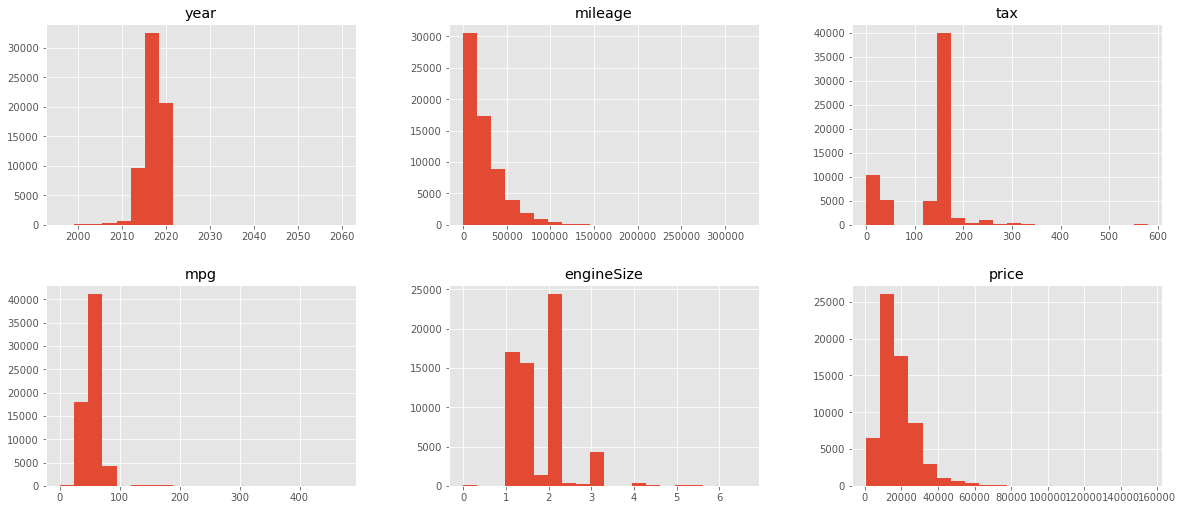

In [18]:
# Посмотрим на распределения количественных переменных в train_df
train_df[numeric_columns].hist(figsize=(20, 8.5), layout=(2, 3), bins=20);

Видно что у целевой переменной `price` тяжёлый правый хвост.

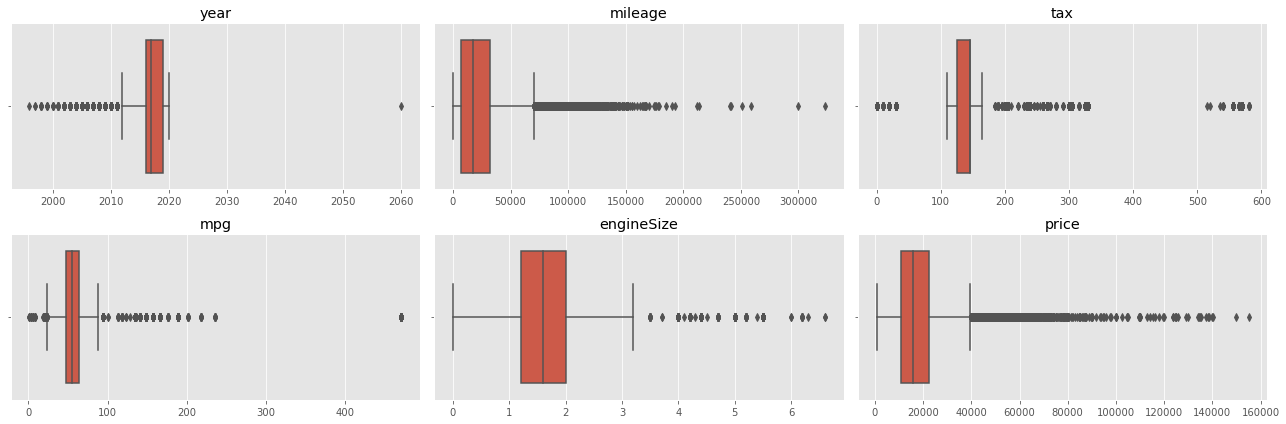

In [19]:
# Посмотрим на распределения количественных переменных с помоьщью боксплот
fig, ax = plt.subplots(2, 3, figsize=(18, 6))

for ax, data in zip(ax.flatten(), numeric_columns):
    sns.boxplot(data=train_df, x=data, ax=ax)
    ax.set(title=data, xlabel='')
plt.tight_layout();

Из разпределений видно, что во всех количественных переменных имеются существенные выбросы. При этом есть ошибка в данных - год выпуска автомобиля 2060. Посмотрим на это наблюдение.

In [20]:
train_df[train_df.year > 2022]

,model,year,transmission,mileage,fuelType,tax,mpg,engineSize,car_maker,price
31534,Fiesta,2060,Automatic,54807,Petrol,205,42.8,1.4,ford,6495


In [21]:
# Исправим год выпуска на среднее значение среди этих моделей с похожими характеристиками
fieata_mean = np.round(train_df.query('model == "Fiesta" & engineSize == 1.4 & fuelType == "Petrol"').year.mean()).astype(int)
train_df.loc[31534, 'year'] = fieata_mean

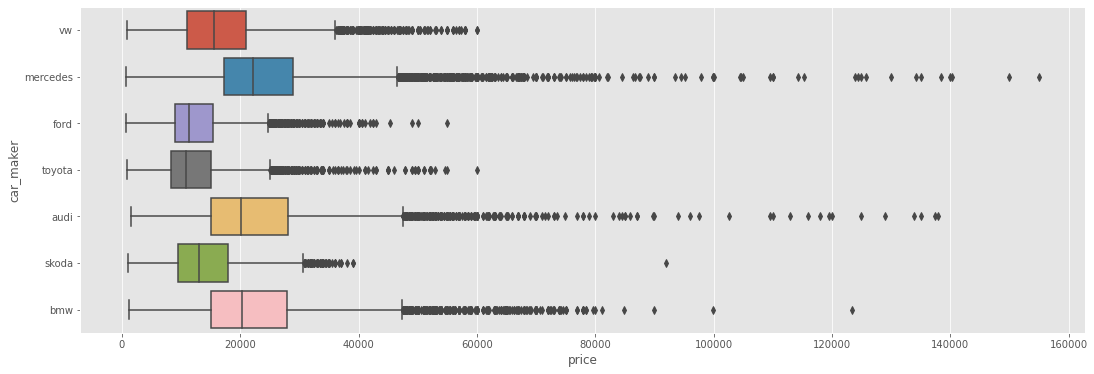

In [22]:
# Посмотрим на распределение стоимости автомобиля в зависимости от производителя
plt.figure(figsize=(18, 6))
sns.boxplot(data=train_df, y='car_maker', x='price');

Стоимость автомобилей марок `Mercedes`, `Audi` и `BMW` в среднем выше.

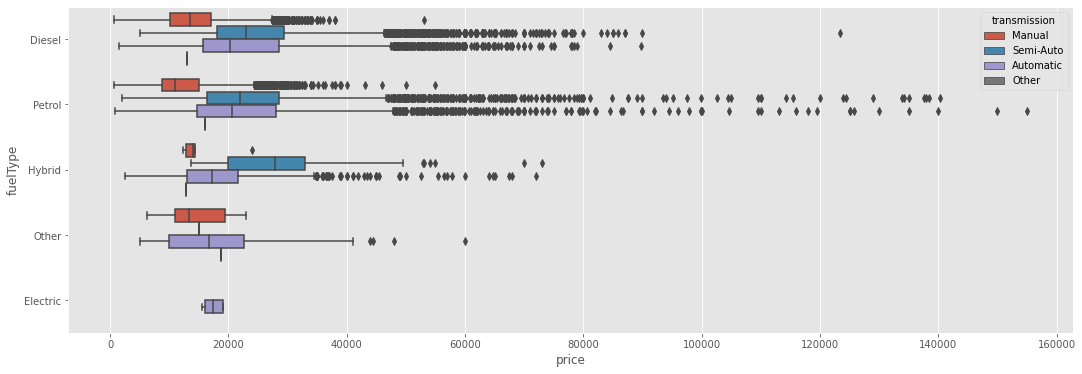

In [23]:
# Посмотрим на распределение стоимости автомобиля в разрезе по типу топлива и трансмиссии
plt.figure(figsize=(18, 6))
sns.boxplot(data=train_df, x='price', y='fuelType', hue='transmission');

Автомобили с полуавтоматической и автоматической коробкой передач в среднем дороже чем автомобили с механической коробкой передач в независимости от типа топлива.

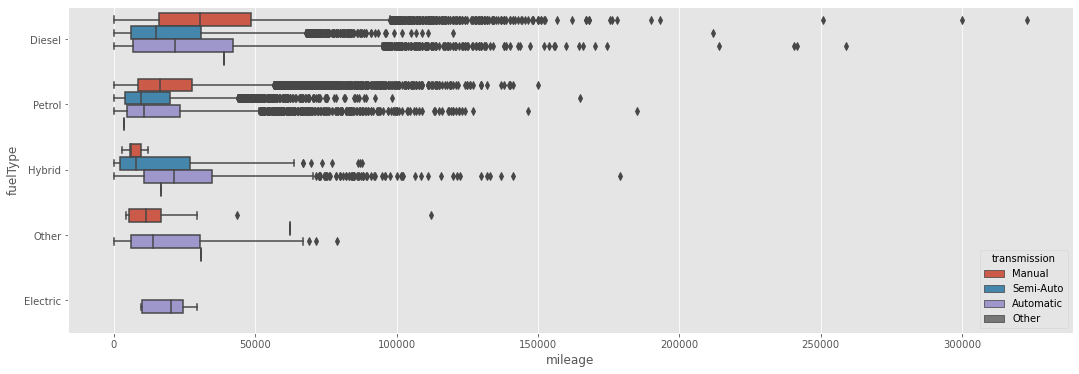

In [24]:
# Посмотрим на пробег автомобиля в зависимости от типа топлива и коробки передач
plt.figure(figsize=(18, 6))
sns.boxplot(data=train_df, y='fuelType', x='mileage', hue='transmission');

У автомобилей с дизельным и бензиновым двигателем и ручной коробкой передач в среднем пробег выше.

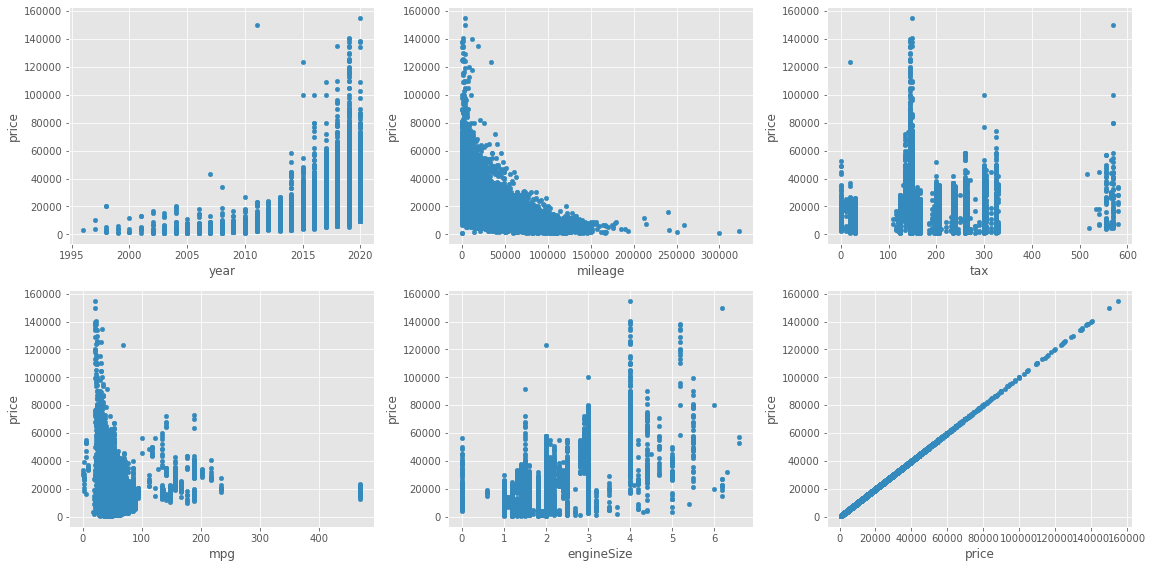

In [25]:
# Посмотрим на диаграмы рассеяния
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(16, 8))
for idx, feature in enumerate(numeric_columns):
    train_df.plot(feature, 'price', subplots=True, kind='scatter', ax=axes[idx//3, idx%3], grid=True)
plt.tight_layout();

Из диаграмм рассеяния можно заметить ряд зависимостей:
- чем выше год производства, тем выше стоимость авто;
- чем меньше пробег в милях, тем дороже автомобиль;
- включенный в стоимость автомобиля налог не имеет заметной линойной зависимости от уровня стоимости;
- с увеличением количества миль, которые авто может проехать на 3,78 литрах топлива, снижается стоимости авто;
- объем двигателя влияет на стоимость автомобиля.

**Расчитаем коэффициент корреляции Пирсона и посмотрим есть ли среди наши признаков мультиколлинеарность.**

In [26]:
# Объявим функцию для визуализации матрицы корреляции Пирсона
def plot_correlation_matrix(df, figsize=(6, 4)):
    plt.figure(figsize=figsize)
    corr_mxt = df.corr()
    mtx = corr_mxt.where(np.triu(np.ones(corr_mxt.shape), k=1).astype(np.bool))
    sns.heatmap(mtx, cmap='YlGnBu', annot=True, fmt='.2f', linewidths=1, annot_kws={'size': 14}, cbar=False)
    plt.show();

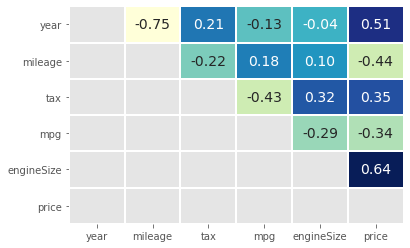

In [27]:
# Визуализируем корреляцию признаков
plot_correlation_matrix(train_df)

Наибольшая линейная зависимость имеется между факторами `year` и `mileage`, при этом очень сильной линейной зависимости меджу переменным нет.

<hr>

### 2. Построение моделей и прогнозирование

Подготовим данные для обучения и тестирования моделей.

In [28]:
x_full = train_df.drop(columns=['price'])
y_full = train_df['price']

In [29]:
num_features = [col for col in x_full.columns if x_full[col].dtype in ['int64', 'float64']]
cat_features = [col for col in x_full.columns if col not in num_features]

Разделим наши данные обучающую выборку и контрольную выборку.

In [30]:
x, x_сontrol, y, y_control = train_test_split(x_full, y_full, train_size=0.7, test_size=0.3, shuffle=True)

Объявим вспомогательную функцию, которая на основании переданных аргументов будет строить модель множественной линейной регрессии с параметрами регуляризации и предобработки вещественных признаков с скалированием и нормализацией и категориальных признаков с помощью OneHotEncoder для кодирования переменных.

In [31]:
def make_model(alpha=0, penalty=None, with_categorical=True):
    if penalty is None:
        regressor = LinearRegression()
    elif penalty == 'L1':
        regressor = Lasso(alpha=alpha, random_state=SEED)
    elif penalty == 'L2':
        regressor = Ridge(alpha=alpha, random_state=SEED)
    
    if with_categorical:
        return pipeline.Pipeline(steps = [
            ('feature_processing', pipeline.FeatureUnion(transformer_list = [
                ('numeric_variables_processing ', pipeline.Pipeline(steps = [
                    # преобразование вещественных признаков с помощью RobustScaler
                    ('selecting', preprocessing.FunctionTransformer(lambda data: data[num_features])),
                    ('scaling', preprocessing.RobustScaler())])
                ),
                ('categorical_variables_processing', pipeline.Pipeline(steps = [
                    # преобразование вещественных признаков с помощью OneHotEncoder
                    ('selecting', preprocessing.FunctionTransformer(lambda data: data[cat_features])),
                    ('hot_encoding', preprocessing.OneHotEncoder(handle_unknown = 'ignore'))])
                )])
            ),
            ('model_fitting', regressor)])
    else:
        return pipeline.Pipeline(steps = [
        ('scaling', RobustScaler()),
        ('model_fitting', regressor)])

**Попробуем обучить модели линейной регрессии только на вещественных признаках.**

In [32]:
display(make_model(with_categorical=False))
display(make_model(penalty='L1', with_categorical=False))
display(make_model(penalty='L2', with_categorical=False))

Pipeline(steps=[('scaling', RobustScaler()),
                ('model_fitting', LinearRegression())])

Pipeline(steps=[('scaling', RobustScaler()),
                ('model_fitting', Lasso(alpha=0, random_state=42))])

Pipeline(steps=[('scaling', RobustScaler()),
                ('model_fitting', Ridge(alpha=0, random_state=42))])

In [33]:
# Разделим выборку для обучения на тестовую и обучающую
x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=0.7, test_size=0.3, shuffle=True, random_state=SEED)

In [34]:
# Вспомогательная функция для возврата результатов прогнозирования линейных моделей 
def make_linear_model_predictions(x_train, y_train, x_test, y_test, x_control, y_control, models, categorical_data=False):
    parameters_grid = {'model_fitting__alpha' : [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1]}
    results = []
    for model in models:
        if model.startswith('Linear'):
            regr = make_model(with_categorical=categorical_data).fit(x_train, np.log(y_train))
            train_mae = mae(y_train, np.exp(regr.predict(x_train))).astype(int)
            test_mae = mae(y_test, np.exp(regr.predict(x_test))).astype(int)
            control_mae = mae(y_control, np.exp(regr.predict(x_control))).astype(int)
            results.append([model, train_mae, test_mae, control_mae, None])
        
        elif model.startswith('L1'):
            L1_regr = make_model(penalty='L1', with_categorical=categorical_data)
            grid = model_selection.GridSearchCV(L1_regr, parameters_grid, scoring='neg_mean_absolute_error', cv=3)
            grid.fit(x_train, np.log(y_train))
            train_mae = mae(y_train, np.exp(grid.best_estimator_.predict(x_train))).astype(int)
            test_mae = mae(y_test, np.exp(grid.best_estimator_.predict(x_test))).astype(int)
            control_mae = mae(y_control, np.exp(grid.best_estimator_.predict(x_control))).astype(int)
            results.append([model, train_mae, test_mae, control_mae, grid.best_params_['model_fitting__alpha']])
            
        elif model.startswith('L2'):
            L2_regr = make_model(penalty='L2', with_categorical=categorical_data)
            grid = model_selection.GridSearchCV(L2_regr, parameters_grid, scoring='neg_mean_absolute_error', cv=3)
            grid.fit(x_train, np.log(y_train))
            train_mae = mae(y_train, np.exp(grid.best_estimator_.predict(x_train))).astype(int)
            test_mae = mae(y_test, np.exp(grid.best_estimator_.predict(x_test))).astype(int)
            control_mae = mae(y_control, np.exp(grid.best_estimator_.predict(x_control))).astype(int)
            results.append([model, train_mae, test_mae, control_mae, grid.best_params_['model_fitting__alpha']])

    return pd.DataFrame(results, columns=['Model', 'MAE Train', 'MAE Test', 'MAE Control', 'Best alhpa'])

In [35]:
# Определим список моделей
models = ['Linear Regression', 'L1 Regression', 'L2 Regression']

# Сделаем прогноз только на вещественных признаках
make_linear_model_predictions(x_train[num_features], y_train,
                              x_test[num_features], y_test, 
                              x_сontrol[num_features], y_control,
                              models, categorical_data=False)

,Model,MAE Train,MAE Test,MAE Control,Best alhpa
0,Linear Regression,3275,3249,3295,NaN
1,L1 Regression,3275,3248,3295,0.0001
2,L2 Regression,3275,3249,3295,0.0001


Обучение моделей только на вещественных признаках дает не очень хорошее качество прогноза – МАЕ намного выше требуемого порогового значения. Качество прогнозных значений не изменяется с использованием регуляризации и подбора гиперпараметра алфа.
<hr>

**Обучение модели на полных данных.**

In [36]:
display(make_model())
display(make_model(penalty='L1'))
display(make_model(penalty='L2'))

Pipeline(steps=[('feature_processing',
                 FeatureUnion(transformer_list=[('numeric_variables_processing ',
                                                 Pipeline(steps=[('selecting',
                                                                  FunctionTransformer(func=<function make_model.<locals>.<lambda> at 0x00000127B3DF9700>)),
                                                                 ('scaling',
                                                                  RobustScaler())])),
                                                ('categorical_variables_processing',
                                                 Pipeline(steps=[('selecting',
                                                                  FunctionTransformer(func=<function make_model.<locals>.<lambda> at 0x00000127B3DF9790>)),
                                                                 ('hot_encoding',
                                                                  OneHotEncoder(handle_unknown='ignore'))]))])),
                ('model_fitting', LinearRegression())])

Pipeline(steps=[('feature_processing',
                 FeatureUnion(transformer_list=[('numeric_variables_processing ',
                                                 Pipeline(steps=[('selecting',
                                                                  FunctionTransformer(func=<function make_model.<locals>.<lambda> at 0x00000127B3DF9700>)),
                                                                 ('scaling',
                                                                  RobustScaler())])),
                                                ('categorical_variables_processing',
                                                 Pipeline(steps=[('selecting',
                                                                  FunctionTransformer(func=<function make_model.<locals>.<lambda> at 0x00000127B3DF9790>)),
                                                                 ('hot_encoding',
                                                                  OneHotEncoder(handle_unknown='ignore'))]))])),
                ('model_fitting', Lasso(alpha=0, random_state=42))])

Pipeline(steps=[('feature_processing',
                 FeatureUnion(transformer_list=[('numeric_variables_processing ',
                                                 Pipeline(steps=[('selecting',
                                                                  FunctionTransformer(func=<function make_model.<locals>.<lambda> at 0x00000127B3DF9700>)),
                                                                 ('scaling',
                                                                  RobustScaler())])),
                                                ('categorical_variables_processing',
                                                 Pipeline(steps=[('selecting',
                                                                  FunctionTransformer(func=<function make_model.<locals>.<lambda> at 0x00000127B3DF9790>)),
                                                                 ('hot_encoding',
                                                                  OneHotEncoder(handle_unknown='ignore'))]))])),
                ('model_fitting', Ridge(alpha=0, random_state=42))])

In [37]:
make_linear_model_predictions(x_train, y_train, x_test, y_test, x_сontrol, y_control, models, categorical_data=True)

,Model,MAE Train,MAE Test,MAE Control,Best alhpa
0,Linear Regression,1784,1786,1778,NaN
1,L1 Regression,1858,1862,1857,0.0001
2,L2 Regression,1810,1813,1809,0.0050


Обучение моделей на полных данных позволяет добиться требуемого порогового значения МАЕ, при этом простая модель множественной регрессии дает в среднем лучший прогноз.<br>
<br>
Поскольку в процессе анализа был сделан вывод разной стоимости автомобилей для разных производителей, попробуем разделить наши выборки на две:
- немецкие автомобили (Audi, BMW, Mercedes и VW)
- другие автомобили (другие производители)

и сделать прогноз для разных сегментов по отдельности.

In [38]:
german_models = ['mercedes', 'audi', 'bmw', 'vw']
german = train_df[train_df.car_maker.isin(german_models)].copy()
others = train_df[~train_df.car_maker.isin(german_models)].copy()

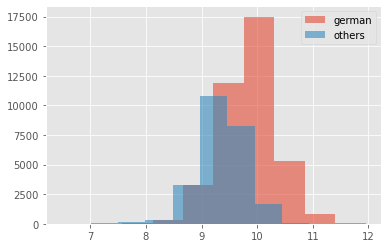

In [39]:
# Посмотрим на распределение логарифма стоимости для двух сегментов
plt.hist(np.log(german.price), alpha=0.6, label='german')
plt.hist(np.log(others.price), alpha=0.6, label='others')
plt.legend();

In [40]:
# Разделим выборку немецкие авто для обучения на тестовую и обучающую
X_german = german.drop(columns=['price'])
Y_german = german['price']

Xpr, Xpr_control, Yp, Ypr_control = train_test_split(X_german, Y_german, train_size=0.8,
                                                     test_size=0.2, shuffle=True, random_state=SEED)

Xpr_train, Xpr_test, Ypr_train, Ypr_test = train_test_split(Xpr,Yp, train_size=0.7, test_size=0.3,
                                                            shuffle=True, random_state=SEED)

In [41]:
make_linear_model_predictions(Xpr_train, Ypr_train, Xpr_test, Ypr_test, Xpr_control, Ypr_control, models, categorical_data=True)

,Model,MAE Train,MAE Test,MAE Control,Best alhpa
0,Linear Regression,2171,2140,2151,NaN
1,L1 Regression,2221,2176,2225,0.0001
2,L2 Regression,2208,2164,2202,0.5000


In [42]:
# Разделим выборку другие производители для обучения на тестовую и обучающую
X_others = others.drop(columns=['price'])
Y_others = others['price']

Xstd, Xstd_control, Ystd, Ystd_control = train_test_split(X_others, Y_others, train_size=0.8, test_size=0.2,
                                                          shuffle=True, random_state=SEED)

Xstd_train, Xstd_test, Ystd_train, Ystd_test = train_test_split(Xstd, Ystd, train_size=0.7, test_size=0.3,
                                                                shuffle=True, random_state=SEED)

In [43]:
make_linear_model_predictions(Xstd_train, Ystd_train, Xstd_test, Ystd_test, 
                              Xstd_control, Ystd_control, models, categorical_data=True)

,Model,MAE Train,MAE Test,MAE Control,Best alhpa
0,Linear Regression,1160,1196,1191,NaN
1,L1 Regression,1169,1207,1196,0.0001
2,L2 Regression,1168,1207,1194,0.0100


Результаты прогноза стоимости автомобилей для других производителей существенно улучшились – объединение результатов прогноза для разных производителей в целом улучшит качество прогноза. **По грубой оценке мы получим МАЕ примерно 1660-1700.**

<br>
Спрогнозируем стоимость автомобилей для разных сегментов, объединим в итоговый файл и отправим в грейдер, посмотрим насколько хорошо получилось у нас сделать прогноз с помощью линейной регресии.

In [44]:
# Разделим данные для прогноза на немецкие автомобили и другие
x_predict_german = x_predict[x_predict.car_maker.isin(german_models)].copy()
x_german_ids = x_predict_german.id

x_predict_others = x_predict[~x_predict.car_maker.isin(german_models)].copy()
x_others_ids = x_predict_others.id

In [45]:
# Обучим модель и предскажем цены для немецких автомобилей
linear_regressor = make_model()

linear_regressor.fit(Xpr_train, np.log(Ypr_train))
german_cars_prediction = np.exp(linear_regressor.predict(x_predict_german.drop(['id'], axis=1))).astype(int)

In [46]:
# Обучим модель и предскажем цены для автомобилей других производителей
linear_regressor.fit(Xstd_train, np.log(Ystd_train))
others_cars_prediction = np.exp(linear_regressor.predict(x_predict_others.drop(['id'], axis=1))).astype(int)

In [47]:
# Объединим спрогназированные значения в итоговый файл
predicted = pd.DataFrame(np.hstack([german_cars_prediction, others_cars_prediction]), columns=['price'])
predicted['id'] = np.int32(np.hstack([x_german_ids, x_others_ids]))

predicted = predicted.sort_values(by='id').reset_index().drop('index', 1)[['id', 'price']]
predicted.head()

,id,price
0,0,10360
1,1,14142
2,2,18081
3,3,19423
4,4,10526


In [48]:
predicted.to_csv('linear_regression_predictions.csv', sep=',', index=False)

> **Грейдер произвел расчеты и присвоил 10 баллов.**
>
> **Таким образом, добиться улучшения результатов прогноза стоимости автомобиля с помощью линейной регрессии позволяет разделение данных по производителю: немецкие автомобили и автомобили других производителей.**

<hr>

### Случайный лес или RandomForestRegressor


Попробуем применить RandomForestRegressor для прогнозирования стоимости автомобилей.

In [49]:
# Объявим алгоритм с заданными гиперпараметрами
rf_model = RandomForestRegressor(random_state=SEED, max_depth=20, n_estimators=50)

In [50]:
# Строим пайплайн для преобразования количественных и категориальных переменных
rf_regressor = pipeline.Pipeline(steps = [       
    ('feature_processing', pipeline.FeatureUnion(transformer_list = [        
            ('numeric_variables_processing', pipeline.Pipeline(steps = [
                ('selecting', preprocessing.FunctionTransformer(lambda data: data[num_features])),
                ('scaling', StandardScaler(with_mean=0))])),
            ('categorical_variables_processing', pipeline.Pipeline(steps = [
                ('selecting', preprocessing.FunctionTransformer(lambda data: data[cat_features])),
                ('hot_encoding', preprocessing.OneHotEncoder(handle_unknown = 'ignore'))])),
        ])),
    ('model_fitting', rf_model)
    ]
)

In [51]:
# Обучаем алгоритм
rf_regressor.fit(x_train, y_train)

Pipeline(steps=[('feature_processing',
                 FeatureUnion(transformer_list=[('numeric_variables_processing',
                                                 Pipeline(steps=[('selecting',
                                                                  FunctionTransformer(func=<function <lambda> at 0x00000127B453AB80>)),
                                                                 ('scaling',
                                                                  StandardScaler(with_mean=0))])),
                                                ('categorical_variables_processing',
                                                 Pipeline(steps=[('selecting',
                                                                  FunctionTransformer(func=<function <lambda> at 0x00000127B453ACA0>)),
                                                                 ('hot_encoding',
                                                                  OneHotEncoder(handle_unknown='ignore'))]))])),
                ('model_fitting',
                 RandomForestRegressor(max_depth=20, n_estimators=50,
                                       random_state=42))])

In [52]:
# Оцениваем качество прогноза на обучающих и отложенных выборках
rf_mae_train = mae(y_train, rf_regressor.predict(x_train)).astype(int)
rf_mae_test = mae(y_test, rf_regressor.predict(x_test)).astype(int)
rf_mae_control = mae(y_control, rf_regressor.predict(x_сontrol)).astype(int)


pd.DataFrame([['RF Regressor', rf_mae_train, rf_mae_test, rf_mae_control]],
             columns=['Model', 'MAE Train', 'MAE Test', 'MAE Control'])

,Model,MAE Train,MAE Test,MAE Control
0,RF Regressor,729,1336,1326


**Результаты прогноза значительно лучше результатов линейной регрессии – МАЕ < 1330 на контрольной выборке.**
<br>

Посмотрим изменится ли качество прогнозирования если будем предсказывать цены для немецких производителей отдельно.

In [53]:
# Обучем алгоритм для прогнозирования стоимости немецких автомобилей
rf_regressor.fit(Xpr_train, Ypr_train)

Pipeline(steps=[('feature_processing',
                 FeatureUnion(transformer_list=[('numeric_variables_processing',
                                                 Pipeline(steps=[('selecting',
                                                                  FunctionTransformer(func=<function <lambda> at 0x00000127B453AB80>)),
                                                                 ('scaling',
                                                                  StandardScaler(with_mean=0))])),
                                                ('categorical_variables_processing',
                                                 Pipeline(steps=[('selecting',
                                                                  FunctionTransformer(func=<function <lambda> at 0x00000127B453ACA0>)),
                                                                 ('hot_encoding',
                                                                  OneHotEncoder(handle_unknown='ignore'))]))])),
                ('model_fitting',
                 RandomForestRegressor(max_depth=20, n_estimators=50,
                                       random_state=42))])

In [54]:
german_train = mae(Ypr_train, rf_regressor.predict(Xpr_train)).astype(int)
german_test = mae(Ypr_test, rf_regressor.predict(Xpr_test)).astype(int)
rf_german_cars_pred = rf_regressor.predict(x_predict_german.drop(['id'], axis=1)).astype(int)


pd.DataFrame([['German Cars', german_train, german_test]],
             columns=['Sample', 'MAE Train', 'MAE Test'])

,Sample,MAE Train,MAE Test
0,German Cars,800,1507


In [55]:
# Обучем алгоритм для прогнозирования стоимости автомобилей других производителей
rf_regressor.fit(Xstd_train, Ystd_train)

Pipeline(steps=[('feature_processing',
                 FeatureUnion(transformer_list=[('numeric_variables_processing',
                                                 Pipeline(steps=[('selecting',
                                                                  FunctionTransformer(func=<function <lambda> at 0x00000127B453AB80>)),
                                                                 ('scaling',
                                                                  StandardScaler(with_mean=0))])),
                                                ('categorical_variables_processing',
                                                 Pipeline(steps=[('selecting',
                                                                  FunctionTransformer(func=<function <lambda> at 0x00000127B453ACA0>)),
                                                                 ('hot_encoding',
                                                                  OneHotEncoder(handle_unknown='ignore'))]))])),
                ('model_fitting',
                 RandomForestRegressor(max_depth=20, n_estimators=50,
                                       random_state=42))])

In [56]:
others_train = mae(Ystd_train, rf_regressor.predict(Xstd_train)).astype(int)
others_test = mae(Ystd_test, rf_regressor.predict(Xstd_test)).astype(int)
rf_others_cars_pred = rf_regressor.predict(x_predict_others.drop(['id'], axis=1)).astype(int)


pd.DataFrame([['Others Cars', others_train, others_test]],
             columns=['Sample', 'MAE Train', 'MAE Test'])

,Sample,MAE Train,MAE Test
0,Others Cars,418,906


Результаты прогноза стоимости автомобилей улучшились – объединение результатов прогноза для разных производителей в целом улучшит качество прогноза. **По грубой оценке мы получим МАЕ примерно 1215.**

In [57]:
# Объединим спрогназированные значения в итоговый файл
rf_predicted = pd.DataFrame(np.hstack([rf_german_cars_pred, rf_others_cars_pred]), columns=['price'])
rf_predicted['id'] = np.int32(np.hstack([x_german_ids, x_others_ids]))

fr_predicted = rf_predicted.sort_values(by='id').reset_index().drop('index', 1)[['id', 'price']]
fr_predicted.head()

,id,price
0,0,10482
1,1,13028
2,2,18124
3,3,20506
4,4,11637


In [58]:
rf_predicted.to_csv('rf_regression_predictions.csv', sep=',', index=False)

<hr>